# Figure 3: contour plots for the basin of attraction over a range of $N_m(0)$ and $N_w(0)$ values

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
from scipy.optimize import fsolve
from scipy.integrate import odeint, solve_ivp
import numpy as np
import time
import pandas as pd
import sympy as sp
import math
import pylab as plt
import matplotlib

Importing required scripts

In [2]:
import importlib
import Hughes_model

Hughes_ODEs = Hughes_model.Hughes_ODEs
F = Hughes_model.F_hughes   # change to F for alternative larval density function

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Solving for the coexistence steady state

In [3]:
# defining parameters as symbols so can solve symbolically
b,nm,nw,u,v,phi,Q,d,dw,h,k = sp.symbols('b nm nw u v phi Q d dw h k') 

zm = (nm*(nm + (1-v)*phi*nw) + nw*((1-u)*nm + (1-v)*phi*nw))/(nm + nw)
zw = v*phi*nw

eq1 = b*zm*sp.exp(-h*(nm+nw)**k) - d*nm   # ODE for wild-types
eq2 = b*phi*v*sp.exp(-h*(nm+nw)**k) - dw  # ODE for Wolbachia-infected, we have taken out a factor nw

### change to below for alternative larval density function
#eq1 = b*zm*(1-(nm + nw)/Q) - d*nm
#eq2 = b*phi*v*(1-(nm + nw)/Q) - dw  # have taken a factor of nw out

sol_coexist = sp.solve([eq1,eq2],[nm,nw])

Convergence checker

In [4]:
def convergence_checker(t, y, u, v, phi, delta, b, d, dw, Q, h, k):
    '''Returns the error between the ODE solution and the steady state value it is converging to.'''
    tolerance = 1e-4      # tolerance we are allowing
    E0 = np.array([0,0])  # extinction state
    E1 = np.array([(np.log(d/b)/-h)**(1/k),0])   # wild-type only
    E2 = np.array([0,(np.log(d*delta/(b*phi*v))/-h)**(1/k)])  # wolbachia only
    max_deviation = min(abs(y - E0).max(), abs(y - E1).max(), abs(y - E2).max())
    
    return max_deviation - tolerance  # returns difference between tolerance and deviation of ODE solution from SS

Parameter values

In [5]:
days = 5000                  # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation

Q = 30        # reproductive carrying capacity
d = 12/100    # per capita death rate
phi = 9/10    # Wolbachia fitness
v = 10/10     # probability of vertical transmission
u = 10/10     # probability that infected male and uninfected female produce inviable offspring
delta = 1     # ratio of Wolbachia-infected death rate versus wild-type
dw = delta*d  # Wolbachia-infected birth rate

k = 0.3           # larval competition parameter
h = 0.19*100**k   # other larval competition parameter
b = round(d/F(10,h,k),2)  # birth rate fitted for Dye's larval density function

tEval = np.linspace(tStart, tEnd)   # output points

In [6]:
print('wild-type SS is', ((np.log(d/b)/-h)**(1/k),0))
print('Wolbachia SS is', (0,(np.log(d*delta/(b*phi*v))/-h)**(1/k)))

nm_co = sol_coexist[1][0].subs({'b':b,'u':u,'v':v,'phi':phi,'Q':Q,'d':d,'dw':dw,'k':k,'h':h}).evalf()
nw_co = sol_coexist[1][1].subs({'b':b,'u':u,'v':v,'phi':phi,'Q':Q,'d':d,'dw':dw,'k':k,'h':h}).evalf()
print('coexistence SS is',(nm_co,nw_co))

wild-type SS is (9.886789309511753, 0)
Wolbachia SS is (0, 7.761054232575853)
coexistence SS is (6.98494880931827, 0.776105423257587)


Solving the ODE system after a long time to find the steady state solution for initial condition $N_m(0)$, $N_w(0)$

In [7]:
params = (u, v, phi, delta, b, d, dw, Q, h, k)  # parameter values fed into ODE solver

nmvec = np.arange(0,31,1)  # array of initial wild-type values
nwvec = np.arange(0,31,1)  # array of initial Wolbachia values
# column corresponds N_m(0) initial condition and row corresponds to N_w(0)
nm_star = np.zeros((len(nmvec),len(nwvec))) # array to hold wild-type ODE solutions
nw_star = np.zeros((len(nmvec),len(nwvec))) # array to hol Wolbachia-only ODE solutions

atol_value = 1e-7  # tolerance settings for ODE solver
rtol_value = 1e-7

for i in range(len(nmvec)):      # looping over initial condition on N_m(0)
    for j in range(len(nwvec)):  # looping over initial condition on N_w(0)
        y0 = np.zeros(2)         # initialising array for intial household state (no. of wild-types and W-infected)
        y0[0] = nmvec[i]         # current initial number of wild-types
        y0[1] = nwvec[j]         # current initial number of W-infected
        
        if y0[0] + y0[1] <= Q:  # check not above bound on household size
            # solving the ODEs after 5000 days
            sol = solve_ivp(Hughes_ODEs, y0 = y0, method='LSODA', t_span = [tStart, tEnd], t_eval = tEval, args=params, atol=atol_value, rtol=rtol_value, events=convergence_checker) 
            sol_df = pd.DataFrame(np.transpose(sol.y)) # putting into data frame
            nm_star[i,j] = sol_df.iloc[len(sol.t)-1,0] # extracting the wild-type solution at 5000 days
            nw_star[i,j] = sol_df.iloc[len(sol.t)-1,1] # extracting the W-infected solution

Classifying which SS attracted to for each initial condition

In [8]:
# initialise vector which stores attracting SS for specified IC
steady_state_col = np.zeros((len(nwvec),len(nmvec))) 

E0 = np.array([0,0])   # extinction SS value
E1 = np.array([(np.log(d/b)/-h)**(1/k),0])    # wild-type only SS  
#E1 = np.array([Q*(1-d/b),0]) for alternative larval density function
E2 = np.array([0,(np.log(d*delta/(b*phi*v))/-h)**(1/k)])   # wolbachia only SS
#E2 = np.array([0,Q*(1-dw/(b*phi*v))]) for alternative larval density function 
E3 = np.array([nm_co,nw_co])  # coexistence SS value

for i in range(len(nmvec)):     # looping over initial condition on N_m(0)  
    for j in range(len(nwvec)):   # looping over initial condition on N_w(0)
        if np.all([nm_star[i,j],nw_star[i,j]]-E0<1e-3):   # if ODE solution close enough to extinction SS
            steady_state_col[i,j] = 0                     # set array entry to 0
        elif np.all([nm_star[i,j],nw_star[i,j]]-E1<1e-3): # if ODE solution close enough to wild-type only SS
            steady_state_col[i,j] = 1                     # set array entry to 1
        elif np.all([nm_star[i,j],nw_star[i,j]]-E2<1e-3): # if ODE solution close enough to Wolbachia only SS
            steady_state_col[i,j] = 2                     # set array entry to 2
        elif np.all([nm_star[i,j],nw_star[i,j]]-E3<1e-3): # if ODE solution close enough to coexistence SS
            steady_state_col[i,j] = 3                     # set array entry to 3 
        if i+j > 30:
            steady_state_col[i,j] = 0      # if initial condition outside of household size bounds, set array to 0

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


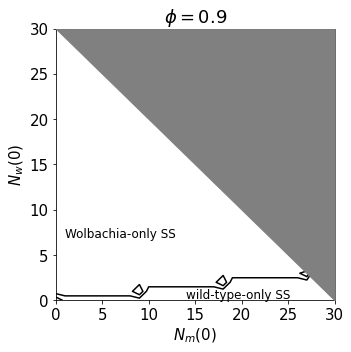

In [9]:
Z = np.transpose(steady_state_col) # swap array to correct way round
np.save('contours_phi09_dye.npy', Z) # save data

plt.figure(figsize=(5, 5)) # figure size
matplotlib.rcParams.update({'font.size': 15})  # font size

plt.xlabel('$N_m(0)$')   # x label
plt.ylabel('$N_w(0)$')   # y label
plt.xticks([0,5,10,15,20,25,30])   # specifying x ticks
x = np.arange(Z.shape[1])  # make array of identical x values

# Calculate contour levels based on data
levels = np.linspace(np.min(Z), np.max(Z), num=5)   # num 5 alters the number of contours shown
# fills in the quadrant above the household size boundary grey
# zorder command ensures grey shading brought to the front
plt.fill_between(x,30-x,np.max(x),color='gray', zorder=10) 
plt.contour(Z, levels=levels, colors='black')  # plot contours defining boundaries for SS attraction

plt.text(1,7,'Wolbachia-only SS',fontsize=12)   # add labels for Wolbachia or wild-type attracting
plt.text(14,0.2,'wild-type-only SS',fontsize=12)

plt.title('$\phi=${}'.format(phi))  # title
plt.savefig('contor_plot_dye_phi09.pdf', bbox_inches='tight')  # save figure